In [1]:
from sat_initial import *

In [2]:
from datastructures.api import (edges_no_param, addf, addobj, addineq, OPT, SolverRef, merge, 
copy_dicts, setsolvefor, var_params)
from datastructures.graphutils import flatten_tree, all_variables, all_edges
from datastructures.tearing import dir_graph, min_arc_set_assign
from datastructures.operators import reformulate, invert_edges
from datastructures.rendering import render_incidence
from datastructures.runpipeline import (model_to_problem, order_from_tree, 
    default_solver_options, mdao_workflow)
from datastructures.postprocess import print_outputs, print_inputs, update_varval
from datastructures.transformations import transform_components
import openmdao.api as om
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [4]:
edges, tree = model.generate_formulation()
edges_nopar =  edges_no_param(model, edges)
outset_initial = {comp: var[0] for comp,var in edges[1].items()}

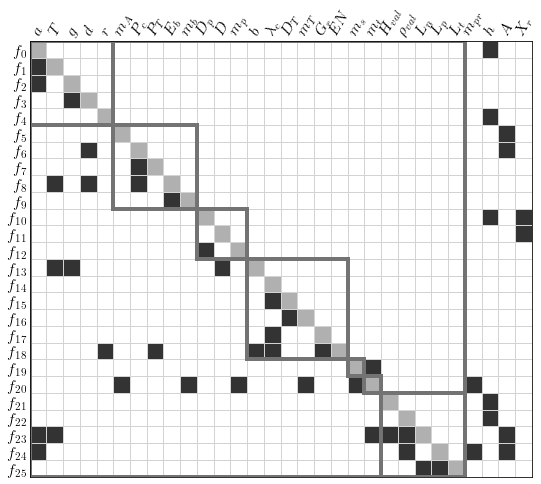

In [5]:
render_incidence(edges_nopar, tree, figname="satellite_default_hsm.png", save=True, rawvarname=True, 
                         dispendcomp=False, hideticks=True, patchwidth=4, figsize=((9,9)));

## Analysis

In [6]:
edges_initial = edges
tree_initial = flatten_tree(tree, 'root')

In [7]:
edges_feedback, tree_feedback = reformulate(edges_initial, tree_initial, outset_initial, mdf=True)
newcomps = transform_components(edges_initial, edges_feedback, model.components, model.idmapping)

In [8]:
newcomps

[(('m_s', 'm_t', '\\eta_S'), 19, (None,), '-\\eta_S*m_t + m_s'),
 (('m_p', 'm_T', 'm_s', 'm_t', 'm_A', 'm_b', 'm_{pr}'), 20, (None,), '-m_A - m_T - m_b - m_p - m_s + m_t - m_{pr}')]

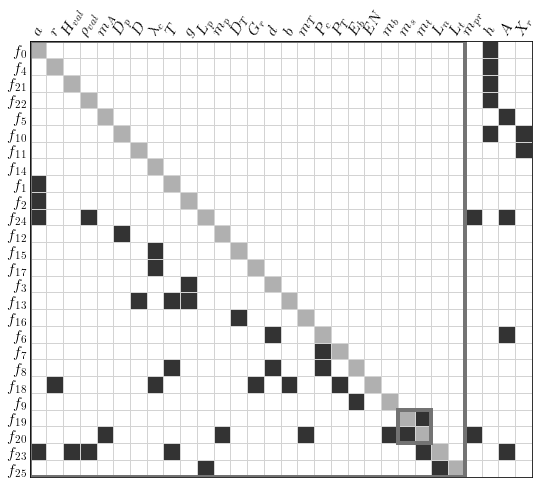

In [9]:
render_incidence(edges_nopar, tree_feedback, rawvarname=True, 
                         dispendcomp=False, hideticks=True, patchwidth=4, figsize=((9,9)));

In [10]:
model.solvers_options[2] = {'solver': 'GS', 'maxiter':20}

In [11]:
prob, mdao_in, groups, namingfunc = model_to_problem(model, 
                        formulation=(edges_feedback, tree_feedback),
                        components=model.components+newcomps)

In [12]:
prob.run_model()


=====
sroot
=====
+  
+  ========
+  sroot.s2
+  ========
+  NL: NLBGS Converged in 1 iterations
+  
+  ========
+  sroot.s2
+  ========
+  NL: NLBGS Converged in 1 iterations
NL: Newton Converged in 1 iterations


In [13]:
print_inputs(model, prob, namingfunc, mdao_in)

$$m_{pr}$$,0.5,kg
$$A$$,0.05,m²
$$h$$,400,km
$$X_r$$,5,m


In [14]:
print_inputs(model, prob, namingfunc, ['m_t','EN', 'L_t'])

$$L_t$$,1.429,yr
$$EN$$,1.084,
$$m_t$$,1.622,kg


In [15]:
print_outputs(model, prob, namingfunc)

$$a$$,6778,km
$$T$$,92.558,min
$$g$$,0.11,
$$d$$,0.61,
$$r$$,2293.992,km
$$m_A$$,0.5,kg
$$P_c$$,12.506,W
$$P_T$$,0.506,W
$$E_b$$,113.874,kJ
$$m_b$$,0.228,kg
$$D_p$$,0.049,m


# Design

## Baseline structure

In [15]:
design_solver = addsolver(m, name="design", idbyname=True)
ENreq = Par('EN_r', 14.125)
addf(design_solver, -Lt+L_min)
addf(design_solver, -EN+ENreq)
setsolvefor(design_solver, [m_pr, A])

In [16]:
formulation = model.generate_formulation()
edges_design, tree_design = merge(formulation, edges_feedback, 
                                  tree_feedback, copysolvers=False)
tree_design[1]['root'] = 'design'
tree_design[1]['design'] = 0
edges_design_noparam = edges_no_param(model, edges_design)

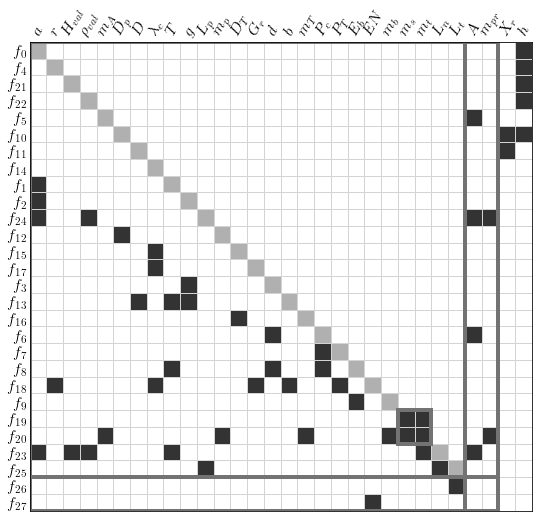

In [17]:
render_incidence(edges_design_noparam, tree_design, figname="satellite_design_unstructured_hsm.png", save=True, rawvarname=True, 
                         dispendcomp=False, hideticks=True, patchwidth=4, figsize=((9,9)));

In [18]:
prob, mdao_in, groups, namingfunc = model_to_problem(model, 
                        formulation=(edges_design, tree_design),
                        components=model.components+newcomps)

In [19]:
import time

In [20]:
start_time = time.time()
prob.run_model()
print("--- %s seconds ---" % (time.time() - start_time))


==
s0
==
NL: Newton Converged in 0 iterations

sdesign
+  
+  =============
+  sdesign.sroot
+  =============
+  +  
+  +  ================
+  +  sdesign.sroot.s2
+  +  ================
+  +  NL: NLBGS Converged in 1 iterations
+  +  
+  +  ================
+  +  sdesign.sroot.s2
+  +  ================
+  +  NL: NLBGS Converged in 1 iterations
+  NL: Newton Converged in 1 iterations
+  
+  =============
+  sdesign.sroot
+  =============
+  +  
+  +  ================
+  +  sdesign.sroot.s2
+  +  ================
+  +  NL: NLBGS Converged in 1 iterations
+  NL: Newton Converged in 0 iterations
+  
+  =============
+  sdesign.sroot
+  =============
+  +  
+  +  ================
+  +  sdesign.sroot.s2
+  +  ================
+  +  NL: NLBGS Converged in 1 iterations
+  NL: Newton Converged in 0 iterations
NL: Newton Converged in 2 iterations
--- 1.3200664520263672 seconds ---


In [21]:
print_inputs(model, prob, namingfunc, ['m_t','EN', 'L_t'])

$$m_t$$,8.449,kg
$$L_t$$,10,yr
$$EN$$,14.125,


## Optimized structure

In [22]:
not_input = {'H_{val}', r'\rho_{val}', 'm_p'}#['m_p']#'d', r'\rho_{val}', 'L_p', 'H_{val}']
not_output = {'L_t','X_r','EN', 'h', 'm_s'}#['h']#[r'm_{rz}', 'm_{r0}']
edges_for_solving = copy_dicts(edges_nopar)
eqnidxs = list(edges_for_solving[1].keys())
varidxs = all_variables(*edges_for_solving)
graph_edges_minassign = all_edges(*edges_for_solving)
edges_left_right = list(dir_graph(graph_edges_minassign, eqnidxs, {}))
xsol,_ = min_arc_set_assign(edges_left_right, varidxs, eqnidxs, not_input, not_output)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [23]:
outset_opt = {right:left for left, right in edges_left_right if (left,right) in edges_left_right and xsol[left, right] > 0.5}

In [26]:
not_outputs = var_params(model, edges_initial) | {'L_t','X_r','EN', 'h'}
edges_minassign, tree_minassign = reformulate(edges_initial, tree_initial, outset_initial, 
                                              outset_opt, not_outputs=not_outputs,
                                              root_solver_name='root', solveforvars=True, mdf=True) # For OPT do not have subproblems so no need to set mdf=True/False
edges_minassign_noparam = edges_no_param(model, edges_minassign)

In [27]:
tree_minassign[1]['root'] = 0

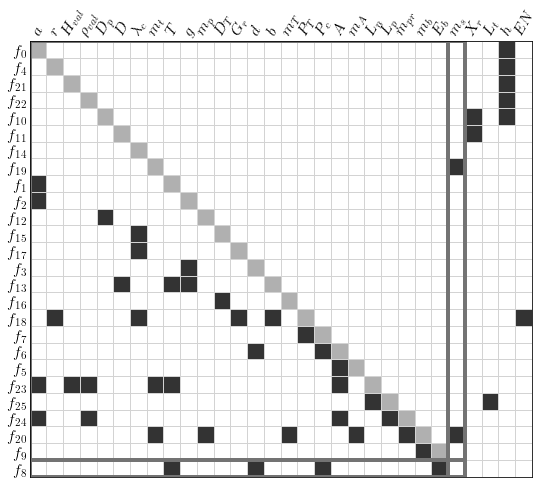

In [28]:
render_incidence(edges_minassign_noparam, tree_minassign, figname="satellite_design_restructured_hsm.png", save=True, rawvarname=True, 
                         dispendcomp=False, hideticks=True, patchwidth=4, figsize=((9,9)));

In [29]:
newcomps_restructure = transform_components(edges_initial, edges_minassign, model.components, model.idmapping)

In [30]:
prob, mdao_in, groups, namingfunc = model_to_problem(model, 
                        formulation=(edges_minassign, tree_minassign),
                        components=model.components+newcomps_restructure)

In [31]:
prob.set_val('L_t', 10)
prob.set_val('EN', 14.125)

In [32]:
start_time = time.time()
prob.run_model()
print("--- %s seconds ---" % (time.time() - start_time))


==
s0
==
NL: Newton Converged in 0 iterations

=====
sroot
=====
NL: Newton Converged in 1 iterations
--- 0.8273353576660156 seconds ---


In [33]:
print_inputs(model, prob, namingfunc, ['m_t','EN', 'L_t'])

$$m_t$$,8.449,kg
$$L_t$$,10,yr
$$EN$$,14.125,
